# <font color = 'orange'>What Topics Mattered Most To Kenyans in 2021 as They Prepared for the 2022 General Elections?</font>

## Set-Up

We will begin by importing the necessary libraries and packages required for the project. These will be helpful in setting up the environment we need to run any analysis and computations with our data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
import calendar
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
import xgboost as xgb
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)
import time
import textwrap

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wanjirumambo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wanjirumambo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wanjirumambo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from scipy.stats import mstats

Importing some functions from the Natural Language Toolkit (nltk)

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel

We will also import some functions from the Scikit-Learn package, which is a very useful tool when building models

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel

## Load the Data

To be able to use our data, we need to access it using its filepath then load it as a dataframe. In this case, we have a subdirectory called 'data' in GitHub where the data is stored. Doing this makes the code usable because it eliminates the need to use a local path on your device that would change every time the notebook has to be used by someone else. 

In [5]:
# get data's file path and store it as a variable
filename = "data/kenya_political_tweets.csv"

# load the data and store it as a dataframe
df = pd.read_csv(filename)

Now that we've loaded the dataset, we need to understand the information it has. This means knowing the dataset's dimensions, columns present, as well as what each row represents.

In [6]:
# viewing the first 5 rows of the dataset
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1396091006030856192,Doomster,Utopia slums,"Alt-left, liberal, pronoun:them",2009-08-23 12:22:53,309,907,8050,False,2021-05-22 13:10:08,@PrettyAmmina The change to the new blue unifo...,NaN,Twitter Web App,0.0,0.0,False
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,I think it's now safe to say President Uhuru K...,NaN,Twitter for Android,0.0,0.0,False
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,@_CrazyKenyan President Uhuru Kenyatta bribed ...,['bbinonsense'],Twitter Web App,0.0,1.0,False
3,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,"As @HonMoses_Kuria has just been saying,Presid...",NaN,Twitter for Android,0.0,0.0,False
4,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,David Murathe the KEMSA thief and President Uh...,NaN,Twitter for Android,2.0,1.0,False


In [7]:
# dataset's dimensions
print(df.shape)
row_nums = df.shape[0]
col_nums = df.shape[1]

print("The dataset has", row_nums, "rows and", col_nums, "columns")

(11723, 16)
The dataset has 11723 rows and 16 columns


As established from the code chunk above, this dataset has 11,723 rows and 16 columns. 

Each row in the dataset represents a unique tweet from a user.

### Column Key


In [8]:
# display the columns 
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

This column key helps us get some more information on what each column in the dataset represents

**id:**                tweet id <br>
**user_name:**         name of user account <br>
**user_location:**     area where user is located <br>
**user_description:**  brief description of the user <br>
**user_created:**      date and time when user first created their account <br>
**user_followers:**    number of followers that the user has <br>
**user_friends:**      number of friends that the user has <br>
**user_favourites:**   number of tweets that a user has marked as favorites <br>
**user_verified:**     indicates whether a user has been verified are not <br>
**date:**              date when tweet was published <br>
**text:**              the actual tweet <br>
**hashtags:**          hashtags used by the user <br>
**source:**            platform the tweet was publised from <br>
**retweets:**          number of retweets a tweet received <br>
**favourites:**        number of people that marked the tweet as favourite <br>
**is_retwet:**         indicates whether the tweet is a retweet or not <br>

## Data Wrangling

Data Wrangling gives as on opportunity to prepare our data for any modeling we may need to do. Below are the steps completed for wrangling: <br>

<ol>
    <li>Formatting variable data types</li>
    <li>Dropping problematic rows</li>
    <li>Renaming columns</li>
    <li>Replacing null values with 0 in columns that need to be an int datatype</li>
    <li>Splitting the date to individual year, month, day, time values</li>

</ol>

#### Column Data Types

In [9]:
# viewing the column data types
df.dtypes

id                   object
user_name            object
user_location        object
user_description     object
user_created         object
user_followers       object
user_friends         object
user_favourites      object
user_verified        object
date                 object
text                 object
hashtags             object
source               object
retweets            float64
favorites           float64
is_retweet           object
dtype: object

All the columns appear as objects except `retweets` and `favorites` which appear as floats. However, this is not what we want. We want any column with numbers to be an `int` data type, any column with text to be a `string` data type, and any column with a true or false value to be a `boolean` data type. <br>

However, on running the code chunk labelled as `#changing column dtypes`, we get a Value Error because the input values of row with index 8992 are mismatched. This means that there were entries that did not match accordingly to the variable names. To get rid of this error, we'll drop the row and proceed with the conversions.

In [10]:
# let's view the problematic row (causing value errors: mismatched input)
df.iloc[8992] # dropping this because formatting is inconsistent (issues with id, and user_created)

id                                                      Entrepreneur.
user_name                                         2017-07-17 17:56:55
user_location                                                      62
user_description                                                  200
user_created                                                      683
user_followers                                                  False
user_friends                                      2021-06-11 06:48:03
user_favourites     @KiruiChebet8 It's very sad that some buffons ...
user_verified                                                     NaN
date                                              Twitter for Android
text                                                                0
hashtags                                                            0
source                                                          False
retweets                                                          NaN
favorites           

In [11]:
# dropping this row
df.drop(8992, inplace = True)

# confirming that the row has been dropped
# if dropping the row is successful, index should return the next row, i.e, what was initially row index 8993
df.iloc[8992]

id                                                1403240075157200896
user_name                                        The Standard Digital
user_location                                         Kenya | Nairobi
user_description                  Kenya's bold newspaper, since 1902.
user_created                                      2009-07-02 11:28:51
user_followers                                                1560326
user_friends                                                      168
user_favourites                                                  1985
user_verified                                                    True
date                                              2021-06-11 06:37:59
text                OPINION: The political heavens have willed tha...
hashtags                                                          NaN
source                                                 Hootsuite Inc.
retweets                                                         10.0
favorites           

Before we proceed to formatting the variable data types, let's: <br>

<ul>
    <li>rename the columns for consistency</li>
    <li>replace nan values with 0 for columns required to have int data types
</ul>

In [12]:
# rename 'user_favourites'
df.rename(columns = {'user_favourites': 'user_favorites'}, inplace = True)

# for columns required to have int dtype, replace nan values with 0
df['user_followers'] = df['user_followers'].fillna(0)
df['user_friends'] = df['user_friends'].fillna(0)
df['user_favorites'] = df['user_favorites'].fillna(0)
df['retweets'] = df['retweets'].fillna(0)
df['favorites'] = df['favorites'].fillna(0)


Now let's change the variable data types

In [13]:
# changing column dtypes
df['user_name'] = df['user_name'].astype('string')
df['user_location'] = df['user_location'].astype('string')
df['user_description'] = df['user_description'].astype('string')
df['user_created'] = pd.to_datetime(df['user_created'])
df['user_followers'] = df['user_followers'].astype("int")
df['user_friends'] = df['user_friends'].astype('int')
df['user_favorites'] = df['user_favorites'].astype('int')
df['user_verified'] = df['user_verified'].astype('bool')
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].astype('string')
df['hashtags'] = df['hashtags'].astype('string')
df['source'] = df['source'].astype('string')
df['retweets'] = df['retweets'].astype('int')
df['favorites'] = df['favorites'].astype('int') 
df['is_retweet'] = df['is_retweet'].astype('bool') 

df.dtypes

id                          object
user_name           string[python]
user_location       string[python]
user_description    string[python]
user_created        datetime64[ns]
user_followers               int64
user_friends                 int64
user_favorites               int64
user_verified                 bool
date                datetime64[ns]
text                string[python]
hashtags            string[python]
source              string[python]
retweets                     int64
favorites                    int64
is_retweet                    bool
dtype: object

Now all the columns have the correct datatypes given the values they hold.

In [14]:
# viewing a sample 
df.sample(n = 10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
6353,1405056357376614401,Stacy,Kenya,Love don't hate strangers you've never met.😘,2018-08-12 09:28:40,40293,32423,142091,False,2021-06-16 06:55:14,This is amazing work being done by the current...,<NA>,Twitter for Android,0,0,False
10621,1404742302556426241,jeffmyself,<NA>,<NA>,2018-05-28 14:35:10,81,210,723,False,2021-06-15 10:07:18,@WilliamsRuto Blogger William Ruto anacomplain 😂,<NA>,Twitter for Android,0,0,False
2114,1395645680144855041,LeadNewsDesk,<NA>,News from around the world Enquiries: LeadNews...,2021-02-03 08:26:46,20,0,0,False,2021-05-21 07:40:34,The first cargo ships have docked at Kenya's n...,<NA>,Twitter Web App,0,0,False
10462,1404847859229462538,jn,nairobi,"Steel builder,",2011-06-15 21:42:33,65,543,659,False,2021-06-15 17:06:45,@karuguti @Kmnthungu @Chepkut_William @William...,<NA>,Twitter for Android,0,0,False
1580,1393829329403105281,Muokatene Ken,Nairobi Kenya,"●CEO AltCo.,Africa & Middle E. ●Consultants ●C...",2014-09-01 11:00:11,1202,2400,742,False,2021-05-16 07:23:02,"@Benn_macharia Stay true to the cause, we are ...",<NA>,Twitter Web App,0,0,False
105,1393507882239414274,Kenya Liaison,Nairobi,Official Kenya Liaison Twitter Account.,2020-04-06 04:33:23,1499,217,285,False,2021-05-15 10:05:43,President Uhuru Kenyatta and President @musebi...,['Somaliland'],Twitter Web App,36,162,False
2179,1395602680597331968,Josephine Waithiru,<NA>,I live and breath politics. Open minded loves...,2020-02-03 11:56:32,1705,1749,6713,False,2021-05-21 04:49:42,Our informal sector have something to be happy...,<NA>,Twitter for Android,3,0,False
10313,1405026043724021763,Frank,<NA>,Corruption will finish my country I stand to b...,2011-01-24 08:19:55,481,610,2366,False,2021-06-16 04:54:47,Mr president we are still waiting for Kemsa ...,<NA>,Twitter for Android,0,0,False
2253,1395465970286792707,William Ruto Jr.,"Camden Town, London","Student,,@ The Great University of Nairobi. Ch...",2019-03-20 16:50:31,316,18,6587,False,2021-05-20 19:46:28,Rigathi Gachagua; Let me tell you David Murath...,<NA>,Twitter Web App,0,0,False
7581,1405615735162945539,Muktar Khalif,<NA>,Freelance writer,2020-04-15 23:24:12,103,446,343,False,2021-06-17 19:58:00,How comes Luos are the only people who can ele...,<NA>,Twitter for Android,1,1,False


Let's dig deeper into the variables to identify what we need and what we do not need

In [15]:
# hashtags
print(df['hashtags'].value_counts())
na_nums = df['hashtags'].isna().sum() 
print('\nNA values present: ', na_nums)

# percentage of na values in hashtags
na_nums_perc = (na_nums / row_nums) * 100
print('Percentage of na_values in hashtag column are {0}%'.format(na_nums_perc))

hashtags
['LamuPortRoars']                      52
['UhuruKenyatta']                      33
['SackMatiangi']                       33
['Kenya']                              29
['JKLive']                             28
                                       ..
['amerix']                              1
['WomenWhoCode', 'SaudiaArabia']        1
['MusaliaBigwave']                      1
['UhuruSuccession', 'KenyaDecides']     1
['gusii']                               1
Name: count, Length: 522, dtype: Int64

NA values present:  10549
Percentage of na_values in hashtag column are 89.98549859251045%


In [16]:
# is_retweet
df['is_retweet'].value_counts()

is_retweet
False    11721
True         1
Name: count, dtype: int64

On viewing this sample dataset we notice that there are variables that do not give us much information about the data. Examples of such variables are `hashtags` and `is_retweet`. For the `hashtags` column, we can see that almost 90% of the values are NAs. On the other hand, for the `is_retweet` column, only 1 value is true and the rest are all false. This makes sense because for this data, it is expected that each entry is a unique tweet. Given these insights, we'll go ahead and drop these columns since they lack sufficient details to support anything else in the data.

In [17]:
# dropping hashtags and is_retweet columns
df_new = df.drop(columns = ['hashtags', 'is_retweet'])
df_new.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,text,source,retweets,favorites
0,1396091006030856192,Doomster,Utopia slums,"Alt-left, liberal, pronoun:them",2009-08-23 12:22:53,309,907,8050,False,2021-05-22 13:10:08,@PrettyAmmina The change to the new blue unifo...,Twitter Web App,0,0
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,I think it's now safe to say President Uhuru K...,Twitter for Android,0,0
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,@_CrazyKenyan President Uhuru Kenyatta bribed ...,Twitter Web App,0,1
3,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,"As @HonMoses_Kuria has just been saying,Presid...",Twitter for Android,0,0
4,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,David Murathe the KEMSA thief and President Uh...,Twitter for Android,2,1


#### Date-Time Formatting

Because the date of the tweet is in datetime format, we need to extract the day, month, and year. This way we can do more targeted analysis if we wanted to determine for example, the range of years represented in the dataset as well as trends in tweeting across day, month, year, or even time.

Let's start by assessing if we have any missing values in the date column

In [18]:
# missing values
print('missing values in date column:', df_new['date'].isna().sum().sum())

missing values in date column: 1


Because we only have one missing value in the date column, we can go ahead and drop it. Before doing so, we can view the row to understand it better. 

In [19]:
# identify the row with the missing value
missing_date = pd.DataFrame(columns = df_new.columns)

# view the row with the missing data
missing_date = df_new[df_new['date'].isna()] # selects rows where only the corresponding value of date is NaN
missing_date

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,text,source,retweets,favorites
8991,1403242610169364482,Ouko Robert,"Nairobi, Kenya",CEO. Wayfic Company.,NaT,0,0,0,True,NaT,<NA>,<NA>,0,0


We also notice that this row also has a couple of other missing values. We can drop the row using its index.

In [20]:
# drop the row
df_new.drop([0, 8991], inplace = True)

# see if the row has been dropped
df_new.iloc[8991]

id                                                1403238260219039747
user_name                                     𝐅𝐫𝐚𝐧𝐤 𝐌𝐭𝐞𝐭𝐞𝐳𝐢 (ʙᴀꜰ)🗨️🇰🇪
user_location                               Westlands, Nairobi, Kenya
user_description    𝐏𝐨𝐥𝐢𝐭𝐢𝐜𝐚𝐥 𝐀𝐧𝐚𝐥𝐲𝐬𝐭||\n\nFocused and a go getter...
user_created                                      2018-02-19 11:42:37
user_followers                                                  16693
user_friends                                                     5326
user_favorites                                                 152526
user_verified                                                   False
date                                              2021-06-11 06:30:46
text                @ahmednasirlaw You can also declare your candi...
source                                            Twitter for Android
retweets                                                           17
favorites                                                         193
Name: 8994, dtype: o

The row with the mssing dates has been dropped. Now we can proceed to splitting the date column so that we can have the info split by year, month, and date.

In [21]:
# split the date column to time date to determine the range of years represented in the dataset
df_new['day'] = df_new['date'].dt.day
df_new['month'] = df_new['date'].dt.month
df_new['year'] = df_new['date'].dt.year
df_new['time'] = df_new['date'].dt.time

df_new.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,text,source,retweets,favorites,day,month,year,time
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,I think it's now safe to say President Uhuru K...,Twitter for Android,0,0,22,5,2021,05:53:33
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,@_CrazyKenyan President Uhuru Kenyatta bribed ...,Twitter Web App,0,1,20,5,2021,17:36:17
3,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,"As @HonMoses_Kuria has just been saying,Presid...",Twitter for Android,0,0,18,5,2021,19:40:15
4,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,David Murathe the KEMSA thief and President Uh...,Twitter for Android,2,1,18,5,2021,07:52:15
5,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,The Kenyan Senate despite having several elite...,Twitter for Android,0,0,17,5,2021,16:49:13


The date has been split as required. However, in this case, extracting the date, month, and year saved the variables as floats. Let's convert this into ints to make the values usable and more meaningful.

In [22]:
# replace any NaNs in the new day, month, year colums and then convert said variables to ints 
# day
df_new['day'] = df_new['day'].astype('int')

# month
df_new['month'] = df_new['month'].astype('int')

# year
df_new['year'] = df_new['year'].astype('int')

df_new.head()


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,text,source,retweets,favorites,day,month,year,time
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,I think it's now safe to say President Uhuru K...,Twitter for Android,0,0,22,5,2021,05:53:33
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,@_CrazyKenyan President Uhuru Kenyatta bribed ...,Twitter Web App,0,1,20,5,2021,17:36:17
3,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,"As @HonMoses_Kuria has just been saying,Presid...",Twitter for Android,0,0,18,5,2021,19:40:15
4,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,David Murathe the KEMSA thief and President Uh...,Twitter for Android,2,1,18,5,2021,07:52:15
5,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,The Kenyan Senate despite having several elite...,Twitter for Android,0,0,17,5,2021,16:49:13


Everything date related now looks cleaner. Moving further, we can update the dataset such that the months are referenced by words instead of numbers for readability and inference purposes. In addition, we can match the dates to the day of the week they were. This will make it possible to study tweet trends by day of the week.<br>

Before proceeding, let's confirm what years are represented in this dataset

In [23]:
# find the range of years represented
print(df_new['year'].min())
print(df_new['year'].max())

2021
2021


This dataset only contains tweets generatated in 2021


In [24]:
# creating a new month column that references the month in words
df_new['month_new'] = pd.to_datetime(df_new['month'], format = '%m').dt.month_name().str[:3]
df_new.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,text,source,retweets,favorites,day,month,year,time,month_new
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,I think it's now safe to say President Uhuru K...,Twitter for Android,0,0,22,5,2021,05:53:33,May
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,@_CrazyKenyan President Uhuru Kenyatta bribed ...,Twitter Web App,0,1,20,5,2021,17:36:17,May
3,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,"As @HonMoses_Kuria has just been saying,Presid...",Twitter for Android,0,0,18,5,2021,19:40:15,May
4,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,David Murathe the KEMSA thief and President Uh...,Twitter for Android,2,1,18,5,2021,07:52:15,May
5,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,The Kenyan Senate despite having several elite...,Twitter for Android,0,0,17,5,2021,16:49:13,May


In [125]:
df_new.shape

(11720, 25)

In [25]:
# creating a new column to match the date to the day of the week
df_new['day_of_week'] = df_new['date'].dt.strftime('%A').str[:3]
df_new.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,text,source,retweets,favorites,day,month,year,time,month_new,day_of_week
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,I think it's now safe to say President Uhuru K...,Twitter for Android,0,0,22,5,2021,05:53:33,May,Sat
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,@_CrazyKenyan President Uhuru Kenyatta bribed ...,Twitter Web App,0,1,20,5,2021,17:36:17,May,Thu
3,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,"As @HonMoses_Kuria has just been saying,Presid...",Twitter for Android,0,0,18,5,2021,19:40:15,May,Tue
4,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,David Murathe the KEMSA thief and President Uh...,Twitter for Android,2,1,18,5,2021,07:52:15,May,Tue
5,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,The Kenyan Senate despite having several elite...,Twitter for Android,0,0,17,5,2021,16:49:13,May,Mon


#### Visualizations

Before proceeding with the EDA to create visualizations, it's important that we check for any missing values in the dataset particularly within our variables of interest. How the missing values are treated will depend on how prevalent they are within the columns.

In [26]:
df_new.isna().sum()

id                     0
user_name              0
user_location       2484
user_description     993
user_created           0
user_followers         0
user_friends           0
user_favorites         0
user_verified          0
date                   0
text                   0
source                 0
retweets               0
favorites              0
day                    0
month                  0
year                   0
time                   0
month_new              0
day_of_week            0
dtype: int64

The only columns that have missing values are `user_location` and `user_description`. Because these two columns are not being used for any analysis, we'll just ignore them. That said, it is important to note that each entry where these missing values are present still provide information within the other variables, hence why we are not dropping them for now. <br>

We can now go ahead and create some visualizations to show the distribution of certain variables.

##### User Followers

Let's start by running summary statistics for this variable. Doing this will give us a better idea of our range of values.

In [27]:
# summary statistics
df_new['user_followers'].describe()

count    1.172000e+04
mean     1.041751e+05
std      4.597549e+05
min      0.000000e+00
25%      2.810000e+02
50%      1.748000e+03
75%      1.194400e+04
max      6.918430e+06
Name: user_followers, dtype: float64

Let's plot a histogram to visualize this distribution.

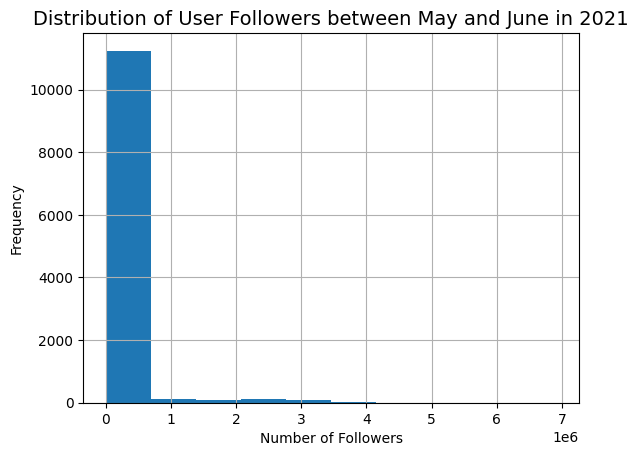

In [28]:
# histogram
df_new['user_followers'].hist()
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')
plt.title('Distribution of User Followers between May and June in 2021', fontsize = 14)

plt.show()


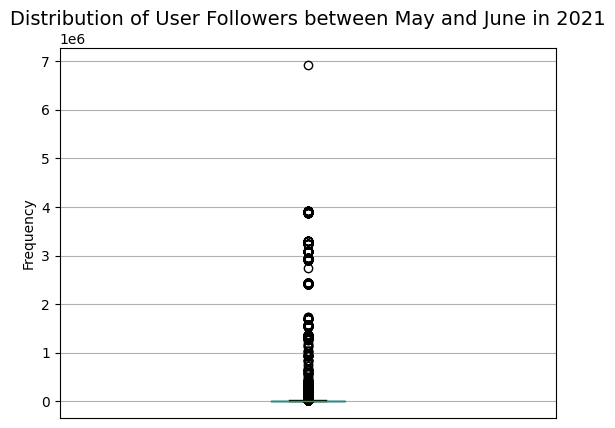

In [29]:
# boxplot
df_new.boxplot(column = 'user_followers')
plt.xticks([])
plt.ylabel('Number of Followers')
plt.ylabel('Frequency')
plt.title('Distribution of User Followers between May and June in 2021', fontsize = 14)

plt.show()

We notice that the data is skewed to the right and most of the values are concentrated to the left. This is a problem because with how the histogram stands at the moment, it doesn't reveal what a typical user following looks like. To rectify this, we can filter out values above the mean and replot the histogram. Hopefully, we can get a better distribution.

old mean: 104175.14701365188
new mean 7201.169505647103


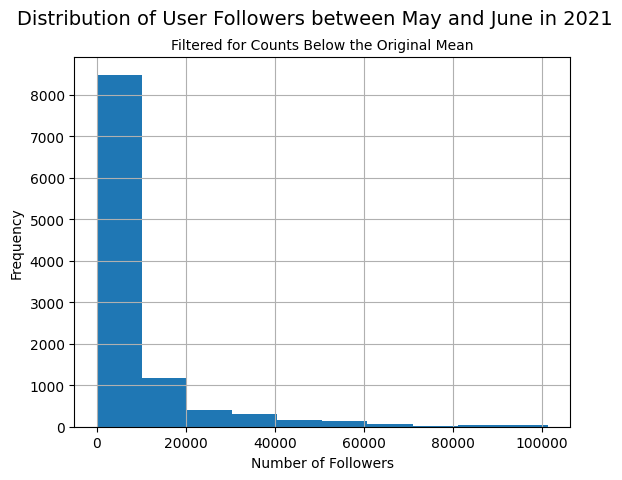

In [30]:
# get the mean and store it as a variable
user_foll_mean = df_new['user_followers'].mean()
print('old mean:', user_foll_mean)

# create a new dataframe that stores the result of filtered values below the mean
user_foll_df = df_new[df_new['user_followers'] <= user_foll_mean]
print('new mean',user_foll_df['user_followers'].mean())

# plot a new histogram
user_foll_df['user_followers'].hist()
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')
plt.suptitle('Distribution of User Followers between May and June in 2021', fontsize = 14, horizontalalignment = 'center')
plt.title('Filtered for Counts Below the Original Mean', fontsize = 10, horizontalalignment = 'center')

plt.show()

# this approach was not filtering out as much as the mean and so I would have to filter out as many times as possible
# user_foll_df = df_new[df_new['user_followers'] <= 0.8 * 10**6]
# user_foll_df['user_followers'].hist()

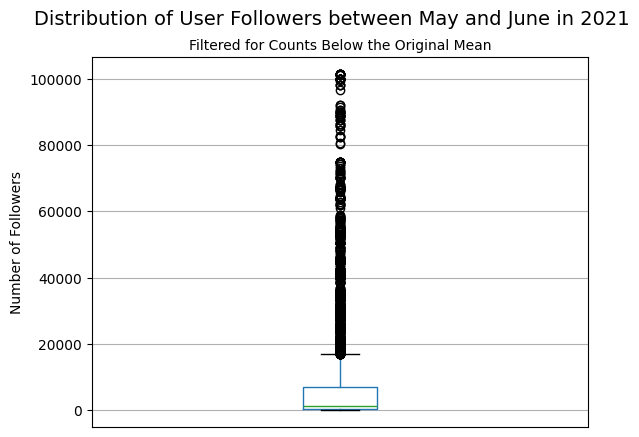

In [31]:
# plot a box plot
user_foll_df.boxplot(column = 'user_followers')
plt.xticks([])
plt.ylabel('Number of Followers')
plt.suptitle('Distribution of User Followers between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below the Original Mean', fontsize = 10)

plt.show()

The histogram is still right skewed, but at least we now have a better idea of where most of our values range, i.e, below 20,000. We can go ahead and filter out anything above that and plot another histogram. We'll continue changing this value until we find one that results in an improved histogram.

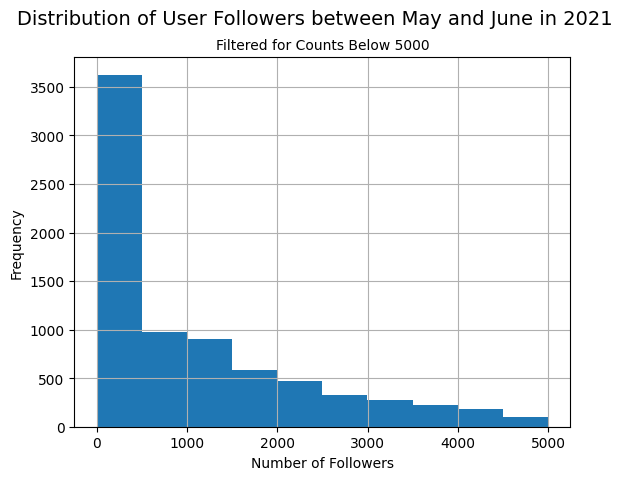

In [32]:
# filter and adjust
# started with 20000, then 10000, then 5000
user_foll_df_new = user_foll_df[user_foll_df['user_followers'] <= 5000]

# histogram
user_foll_df_new['user_followers'].hist()

# label histogram
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')
plt.suptitle('Distribution of User Followers between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 5000', fontsize = 10)

plt.show()

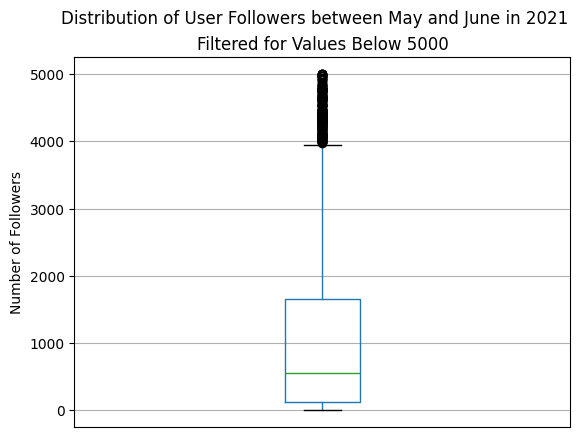

In [33]:
# boxplot
user_foll_df_new.boxplot(column = 'user_followers')

# label
plt.xticks([])
plt.ylabel('Number of Followers')
plt.suptitle('Distribution of User Followers between May and June in 2021')
plt.title('Filtered for Values Below 5000')

plt.show()

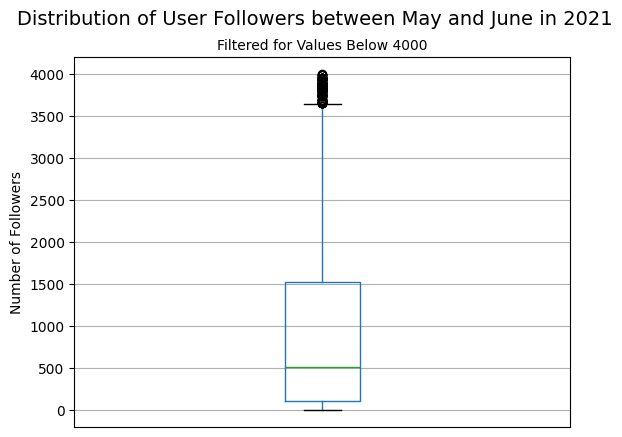

In [34]:
# filter and adjust
# started with 20000, then 10000, then 5000, then 4000, then 3500, then 3000, then 2800
user_foll_df_new = user_foll_df[user_foll_df['user_followers'] <= 4000]
user_foll_df_new.boxplot(column = 'user_followers')

# label
plt.xticks([])
plt.ylabel('Number of Followers')
plt.suptitle('Distribution of User Followers between May and June in 2021', fontsize = 14)
plt.title('Filtered for Values Below 4000', fontsize = 10)

plt.show()

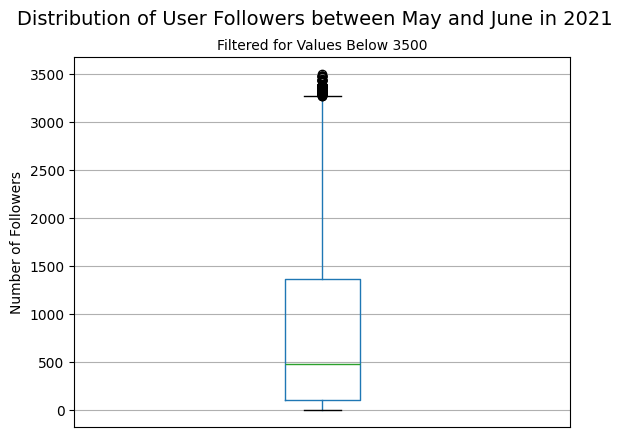

In [35]:
# then 3500, then 3000, then 2800
user_foll_df_new = user_foll_df[user_foll_df['user_followers'] <= 3500]
user_foll_df_new.boxplot(column = 'user_followers')

# label
plt.xticks([])
plt.ylabel('Number of Followers')
plt.suptitle('Distribution of User Followers between May and June in 2021', fontsize = 14)
plt.title('Filtered for Values Below 3500', fontsize = 10)

plt.show()

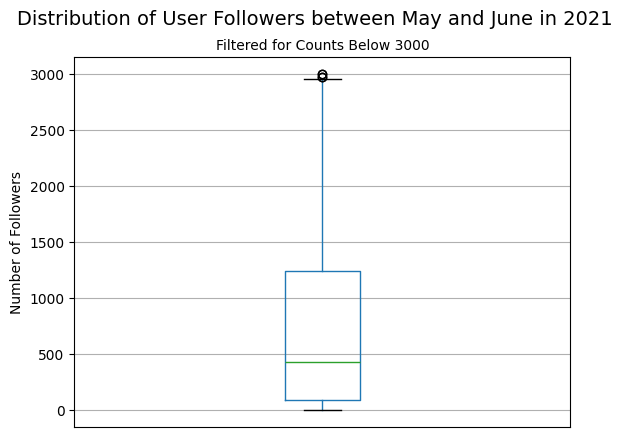

In [36]:
# filter and adjust
# started with 20000, then 10000, then 5000, then 4000, then 3500, then 3000, then 2800
user_foll_df_new = user_foll_df[user_foll_df['user_followers'] <= 3000]
user_foll_df_new.boxplot(column = 'user_followers')

# label
plt.xticks([])
plt.ylabel('Number of Followers')
plt.suptitle('Distribution of User Followers between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 3000', fontsize = 10)

plt.show()

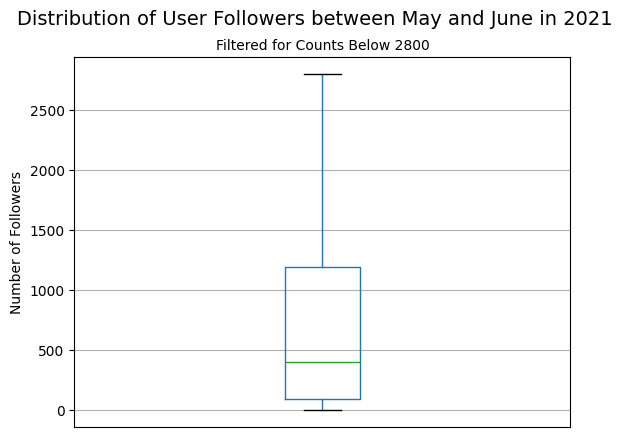

In [37]:
# filter and adjust
# started with 20000, then 10000, then 5000, then 4000, then 3500, then 3000, then 2800
user_foll_df_new = user_foll_df[user_foll_df['user_followers'] <= 2800]
user_foll_df_new.boxplot(column = 'user_followers')

# label
plt.xticks([])
plt.ylabel('Number of Followers')
plt.suptitle('Distribution of User Followers between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 2800', fontsize = 10)

plt.show()

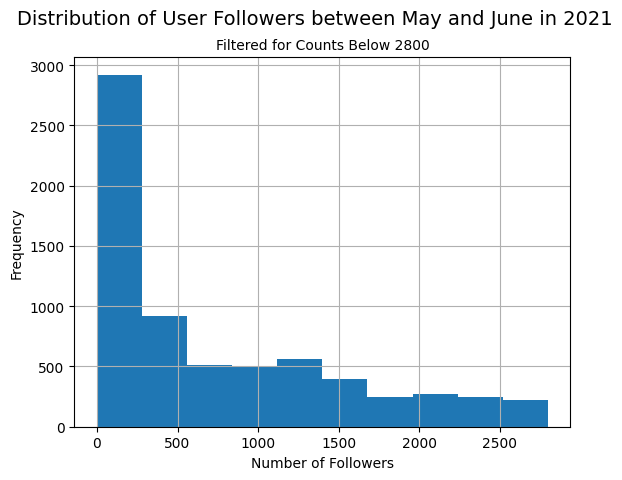

In [38]:
# resulting histogram
user_foll_df_new['user_followers'].hist()

# label histogram
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')
plt.suptitle('Distribution of User Followers between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 2800', fontsize = 10)

plt.show()

The best histogram and boxplot are achieved by filtering out values above 2800 as seen above. This resulting histogram is the most representative of the distribution of `user_followers`. As such, any value above 2,800 is classfied as an outlier.

##### User Friends

Apply a process similar to the steps above to plot a distribution for `user_friends`

In [39]:
# summary statistics
df_new['user_friends'].describe()

count     11720.000000
mean       3856.802645
std       10453.703903
min           0.000000
25%         247.000000
50%         987.000000
75%        3615.750000
max      135540.000000
Name: user_friends, dtype: float64

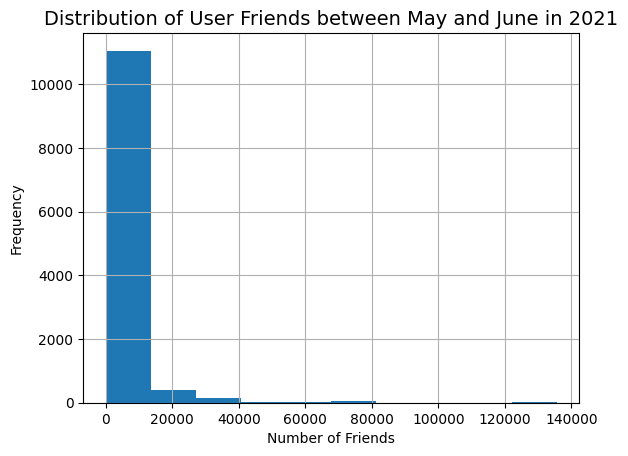

In [40]:
# histogram to show this initial distribution
df_new['user_friends'].hist()

# label histogram
plt.xlabel('Number of Friends')
plt.ylabel('Frequency')
plt.title('Distribution of User Friends between May and June in 2021', fontsize = 14)

plt.show()

The histogram is skewed to the right. This means that we have to filter out extreme values. In this case, because the values are not as extreme as those in `user_followers`, we won't use the mean as a filtering criteria. We can go ahead and filter out values above 20000. This process can be repeated with different values until an ideal histogram is achieved.

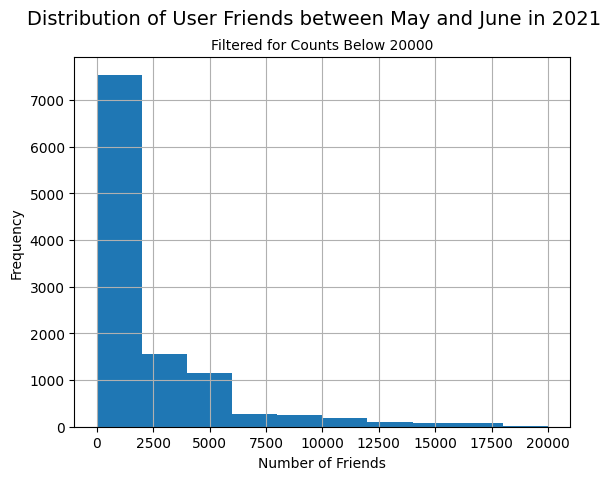

In [41]:
# filter values above 20000
user_fnd_df = df_new[df_new['user_friends'] <= 20000]

# replot histogram
user_fnd_df['user_friends'].hist()

# label histogram
plt.xlabel('Number of Friends')
plt.ylabel('Frequency')
plt.suptitle('Distribution of User Friends between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 20000', fontsize = 10)

plt.show()

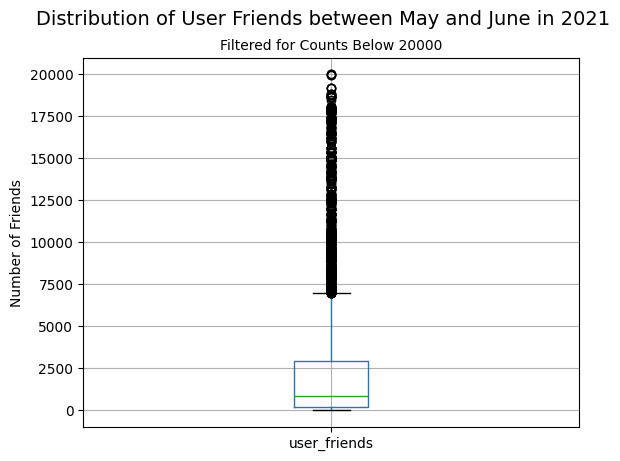

In [42]:
# boxplot
user_fnd_df.boxplot(column = 'user_friends')

# label
plt.xlabel(None)
plt.ylabel('Number of Friends')
plt.suptitle('Distribution of User Friends between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 20000', fontsize = 10)

plt.show()

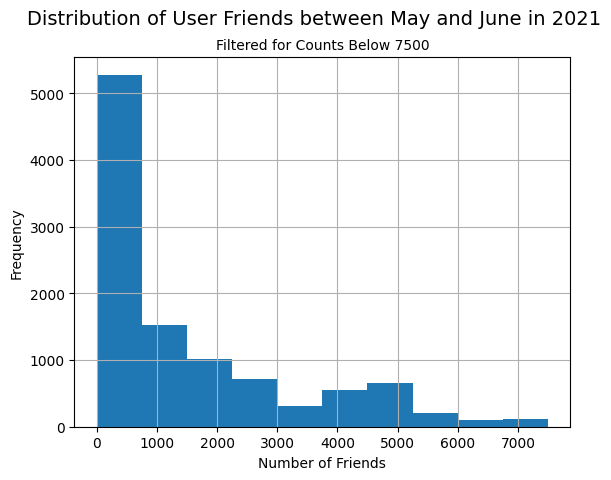

In [43]:
# filter and adjust
user_fnd_df_new = user_fnd_df[user_fnd_df['user_friends'] <= 7500]

# histogram
user_fnd_df_new['user_friends'].hist()

# label
plt.xlabel('Number of Friends')
plt.ylabel('Frequency')
plt.suptitle('Distribution of User Friends between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 7500', fontsize = 10)

plt.show()

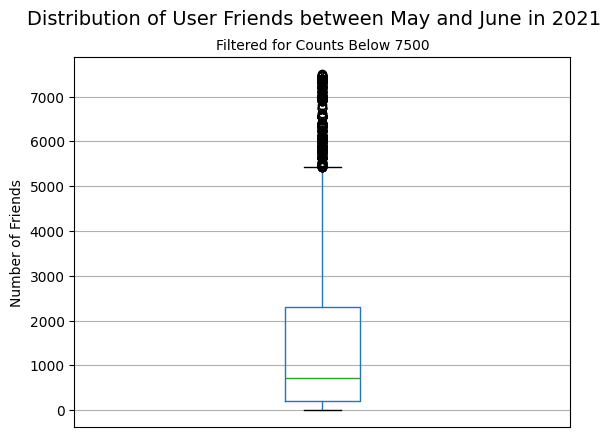

In [44]:
# boxplot
user_fnd_df_new.boxplot(column = 'user_friends')

# label
plt.xticks([])
plt.ylabel('Number of Friends')
plt.suptitle('Distribution of User Friends between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 7500', fontsize = 10)

plt.show()

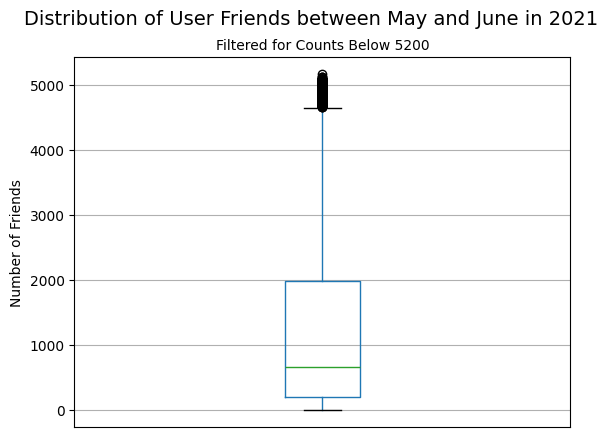

In [45]:
# filter and adjust
user_fnd_df_new = user_fnd_df[user_fnd_df['user_friends'] <= 5200]

# boxplot
user_fnd_df_new.boxplot(column = 'user_friends')

# label
plt.xticks([])
plt.ylabel('Number of Friends')
plt.suptitle('Distribution of User Friends between May and June in 2021 ', fontsize = 14)
plt.title('Filtered for Counts Below 5200', fontsize = 10)

plt.show()

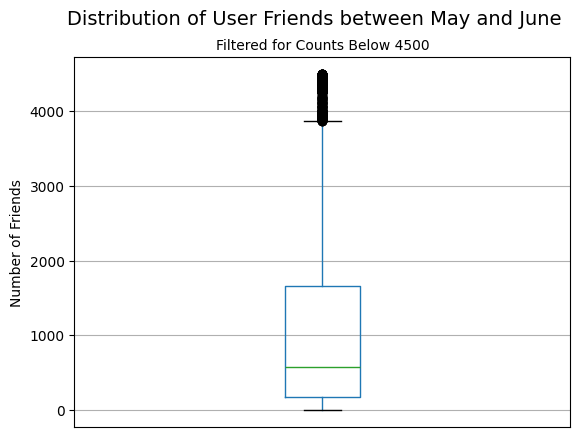

In [46]:
# filter and adjust
user_fnd_df_new = user_fnd_df[user_fnd_df['user_friends'] <= 4500]

# boxplot
user_fnd_df_new.boxplot(column = 'user_friends')

# label
plt.xticks([])
plt.ylabel('Number of Friends')
plt.suptitle('Distribution of User Friends between May and June', fontsize = 14)
plt.title('Filtered for Counts Below 4500', fontsize = 10)

plt.show()

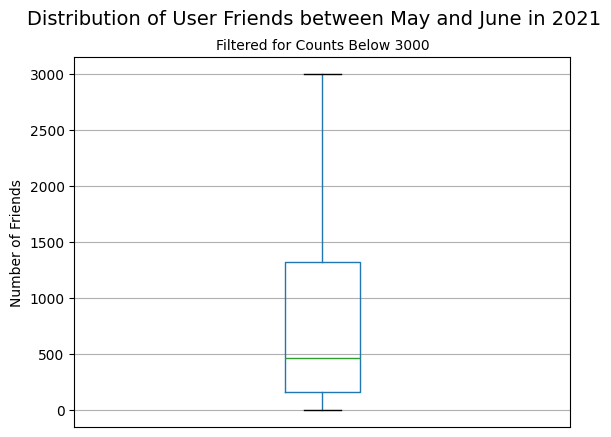

In [47]:
# filter and adjust
user_fnd_df_new = user_fnd_df[user_fnd_df['user_friends'] <= 3000]

# boxplot
user_fnd_df_new.boxplot(column = 'user_friends')

# label
plt.xticks([])
plt.ylabel('Number of Friends')
plt.suptitle('Distribution of User Friends between May and June in 2021', fontsize = 14)
plt.title('Filtered for Counts Below 3000', fontsize = 10)

plt.show()

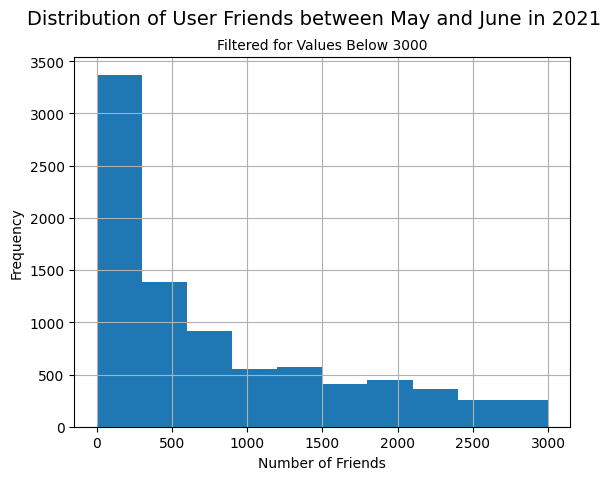

In [48]:
# histogram
user_fnd_df_new['user_friends'].hist()

# label
plt.xlabel('Number of Friends')
plt.ylabel('Frequency')
plt.suptitle('Distribution of User Friends between May and June in 2021', fontsize = 14)
plt.title('Filtered for Values Below 3000', fontsize = 10)

plt.show()

The best histogram and boxplt are achieved by filtering out values above 2800 as seen above. This resulting histogram is the most representative of the distribution of `user_friends`. As such, any value above 3,000 is classfied as an outlier.

##### Verified Users

Let's check the distribution of tweets depending on whether they come from verified users or not.

total number of verified users: 877
total number of users that are not verified: 10845
total number of users: 11722
---------------------
displaying dataframe:

   user_verified  count  percentage
0      verified    877        7.48
1  not_verified  10845       92.52
----------------------
visualizing this distribution


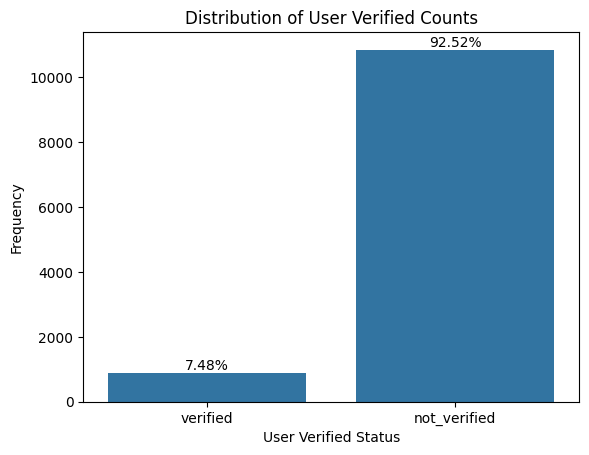

In [49]:
# count who is verified and who isn't
ver_count = (df['user_verified'] == True).sum()
not_ver_count = (df['user_verified'] == False).sum()
total_count = ver_count + not_ver_count
ver_perc = round(((ver_count / total_count) * 100), 2)
not_ver_perc = round(((not_ver_count / total_count) * 100), 2)

# display the counts
print('total number of verified users:', ver_count)
print('total number of users that are not verified:', not_ver_count)
print('total number of users:', total_count)
print('---------------------')

# creae a dataframe with this info
df_new_ver = pd.DataFrame({'user_verified': ['verified', 'not_verified'],
                       'count': [ver_count, not_ver_count],
                       'percentage': [ver_perc, not_ver_perc]})

# view the dataframe
print('displaying dataframe:')
print('\n', df_new_ver.head())

# visualization
print('----------------------')
print('visualizing this distribution')

# label barplot
sns.barplot(data = df_new_ver, x = df_new_ver['user_verified'], y = df_new_ver['count'])
plt.xlabel('User Verified Status')
plt.ylabel('Frequency')

# annotate the percentages on each bar
for i, count in enumerate(df_new_ver['count']):
    plt.text(i, count, f'{df_new_ver.iloc[i]["percentage"]}%', ha = 'center', va = 'bottom')
    
plt.title('Distribution of User Verified Counts')

plt.show()


We can see that the number of users who are not verified on the platform is higher than the number of those verified. Verified users are only 7.48% while non-verified users are 92.52%. This can be indicator of Twitter being a free platform where anyone can engage without having verification status restrictions.

##### Tweets across Months

Let's see what the tweet activity looked like across different months in 2021.

In [50]:
# creating a frequency table
print('displaying the frequency table...')
mth_twt_frq = df_new['month_new'].value_counts().reset_index()
mth_twt_frq.columns = ['month', 'count']
print(mth_twt_frq)

displaying the frequency table...
  month  count
0   May   5951
1   Jun   5769


Our dataset only contains tweets collected between the months of May and June in 2021. Is there a particular reason why?

In [51]:
# count the total entries (verification purposes)
total_count = df_new['month_new'].value_counts().sum()
print('total values:', total_count)

total values: 11720


In [52]:
# data check -> refer note about potential double counting in verified users/why the discrepancies
df_new.shape

(11720, 20)

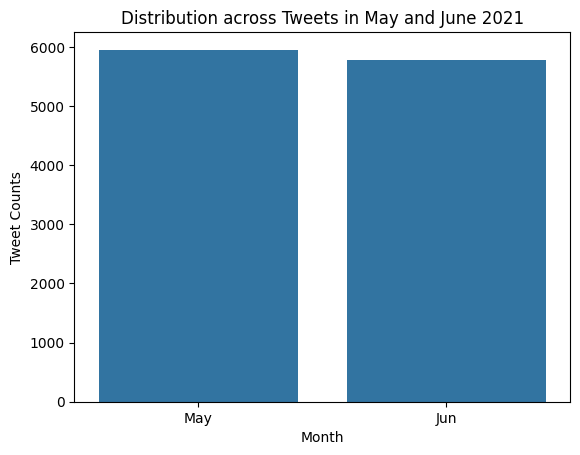

In [53]:
# bar plot
sns.barplot(data = mth_twt_frq, x = 'month', y = 'count')

# label
plt.xlabel('Month')
plt.ylabel('Tweet Counts')
plt.title('Distribution across Tweets in May and June 2021')
plt.show()

The overall number of tweets publishes across both months is almost equal.

##### Tweets across Day of the Week

Let's get a bit more specific and see how tweet activity looked like across different days of the week between these months.

In [54]:
# creating a frequency table
print('displaying a frequency table...')
day_twt_frq = df_new['day_of_week'].value_counts().reset_index()
day_twt_frq.columns = ['day', 'count']
print(day_twt_frq)

displaying a frequency table...
   day  count
0  Thu   2311
1  Wed   2234
2  Fri   1687
3  Sat   1667
4  Tue   1486
5  Sun   1366
6  Mon    969


Create a barplot to show this distribution.

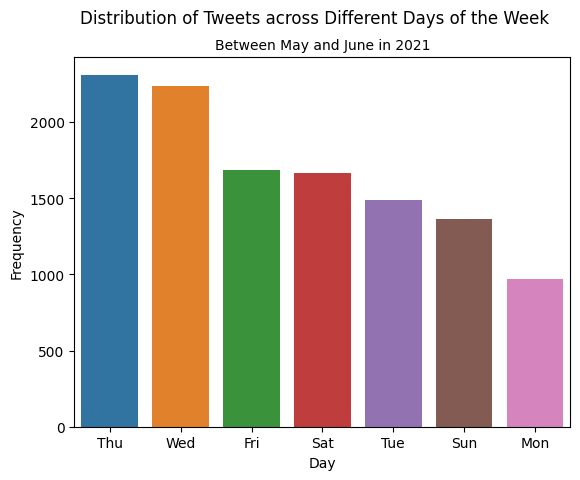

In [55]:
# barplot
sns.barplot(data = day_twt_frq, x = 'day', y = 'count', hue = 'day')

# label
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.suptitle('Distribution of Tweets across Different Days of the Week')
plt.title('Between May and June in 2021', fontsize = 10)
plt.show()

Thursdays appear to be when most people tweet followed by Wednesdays. Fridays, Saturdays, and Tuesdays had less activity compared to Thursdays and Wednesdays. On the other hand, tweet activity was the least on Mondays.

In [56]:
# funtion that will get classify a time stamp to time of day
def specify_time_of_day(curr_timestamp):   
    # classify different time ranges to time of day
    if datetime.time(4, 0, 0) <= curr_timestamp < datetime.time(8, 0, 0):
        return 'early morning'
    elif datetime.time(8, 0, 0) <= curr_timestamp < datetime.time(12, 0, 0):
        return 'mid morning'
    elif datetime.time(12, 0, 0) <= curr_timestamp < datetime.time(16, 0, 0):
        return 'afternoon'
    elif datetime.time(16, 0, 0) <= curr_timestamp < datetime.time(19, 0, 0):
        return 'early evening'
    elif datetime.time(19, 0, 0) <= curr_timestamp < datetime.time(22, 0, 0):
        return 'late evening'
    elif datetime.time(22, 0, 0) <= curr_timestamp <= datetime.time(23, 59, 59):
        return 'night'
    elif datetime.time(0, 0, 0) <= curr_timestamp < datetime.time(4, 0, 0):
        return 'night'
    
# apply the function to time and create a new column
df_new['time_of_day'] = df_new['time'].apply(specify_time_of_day)

df_new.head()


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,...,source,retweets,favorites,day,month,year,time,month_new,day_of_week,time_of_day
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,...,Twitter for Android,0,0,22,5,2021,05:53:33,May,Sat,early morning
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,...,Twitter Web App,0,1,20,5,2021,17:36:17,May,Thu,early evening
3,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,...,Twitter for Android,0,0,18,5,2021,19:40:15,May,Tue,late evening
4,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,...,Twitter for Android,2,1,18,5,2021,07:52:15,May,Tue,early morning
5,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,...,Twitter for Android,0,0,17,5,2021,16:49:13,May,Mon,early evening


##### Tweets Across Time of Day

In [57]:
# create a frequency table for time_of_day
print('displaying a frequency table...')
twt_td_frq = df_new['time_of_day'].value_counts().reset_index()
twt_td_frq.columns = ['time_of_day', 'count']
print(twt_td_frq)

displaying a frequency table...
     time_of_day  count
0  early morning   3086
1    mid morning   2910
2      afternoon   2544
3  early evening   1737
4   late evening    901
5          night    542


In [58]:
# function to wrap the labes on the x-axis
def wrap_text(ax, width, break_long_words = False):
  labels = []
  for label in ax.get_xticklabels():
    text = label.get_text()
    labels.append(textwrap.fill(text, width = width, break_long_words = break_long_words))
  ax.set_xticklabels(labels, rotation = 0)

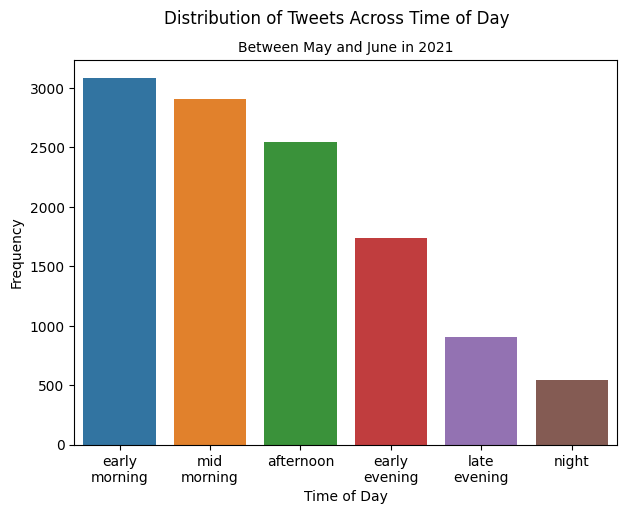

In [59]:
# create a scatterplot to visualize this
fig, ax = plt.subplots(figsize = (7, 5))
sns.barplot(data = twt_td_frq, x = 'time_of_day', y = 'count', hue = 'time_of_day')
plt.xlabel('Time of Day')
plt.ylabel('Frequency')
plt.suptitle('Distribution of Tweets Across Time of Day')
plt.title('Between May and June in 2021', fontsize = 10)
wrap_text(ax, 2)
plt.show()

# fill format in r -- stacked barchart (proportions) height of 1

In [60]:
# length of tweet
def length_of_tweet(twt):
    twt_len = len(twt)
    return twt_len

# apply function to the tweet text
df_new['twt_length'] = df_new['text'].apply(length_of_tweet)
df_new.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,...,retweets,favorites,day,month,year,time,month_new,day_of_week,time_of_day,twt_length
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,...,0,0,22,5,2021,05:53:33,May,Sat,early morning,112
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,...,0,1,20,5,2021,17:36:17,May,Thu,early evening,138
3,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,...,0,0,18,5,2021,19:40:15,May,Tue,late evening,140
4,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,...,2,1,18,5,2021,07:52:15,May,Tue,early morning,139
5,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,...,0,0,17,5,2021,16:49:13,May,Mon,early evening,140


In [61]:
# tweet engagement
# formula: (((favorites + retweets)/tweet)/user_followers)*100
# user_name frq table -> get the count of tweets by user
user_name_frqTbl = df_new['user_name'].value_counts().reset_index()
user_name_frqTbl.columns = ['user_name', 'tweet_count_by_user']
print(user_name_frqTbl) # ***save counts by user name***

                       user_name  tweet_count_by_user
0              Who is John Galt?                  185
1     Kings Research Consultancy                  129
2                  Nation Africa                  116
3          Abuga Makori EGH, MBE                   87
4           The Standard Digital                   81
...                          ...                  ...
4190               @mwanikijones                    1
4191               Ahmeyern haji                    1
4192                        John                    1
4193            THE SECRET PLACE                    1
4194                       Keith                    1

[4195 rows x 2 columns]


In [62]:
# merge the frequency table to the new dataframe
df_new = df_new.merge(user_name_frqTbl, on = 'user_name', how = 'left')
df_new.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,...,favorites,day,month,year,time,month_new,day_of_week,time_of_day,twt_length,tweet_count_by_user
0,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,...,0,22,5,2021,05:53:33,May,Sat,early morning,112,1
1,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,...,1,20,5,2021,17:36:17,May,Thu,early evening,138,4
2,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,...,0,18,5,2021,19:40:15,May,Tue,late evening,140,6
3,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,...,1,18,5,2021,07:52:15,May,Tue,early morning,139,6
4,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,...,0,17,5,2021,16:49:13,May,Mon,early evening,140,6
5,1394014196610781189,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-16 19:37:38,...,1,16,5,2021,19:37:38,May,Sun,late evening,140,6
6,1393619973524832257,G.G Peter Atom,Nairobi,"God Gave me wisdom, empowered me to search for...",2011-10-06 08:19:42,117,308,1839,False,2021-05-15 17:31:08,...,0,15,5,2021,17:31:08,May,Sat,early evening,132,1
7,1393618298684727298,Nyandarua County Government,Kenya,Official twitter account of Nyandarua County G...,2016-10-13 14:25:52,1926,170,361,False,2021-05-15 17:24:29,...,0,15,5,2021,17:24:29,May,Sat,early evening,140,1
8,1393615018642579461,Suleiman H Sandhere,Somaliland,8th president of the Republic of Somaliland. I...,2017-06-19 19:52:31,59,335,66,False,2021-05-15 17:11:27,...,0,15,5,2021,17:11:27,May,Sat,early evening,140,1
9,1393611039552458763,Daudi,Kejani,Make choices that suit you,2019-06-28 08:08:55,1675,2615,4405,False,2021-05-15 16:55:38,...,0,15,5,2021,16:55:38,May,Sat,early evening,122,24


In [63]:
# check
sample_df1 = user_name_frqTbl[user_name_frqTbl['user_name'].str.contains('Lecturer')]
print(sample_df1)
sample_df2 = user_name_frqTbl[user_name_frqTbl['user_name'].str.contains('Daudi')]
print(sample_df2)

       user_name  tweet_count_by_user
372  Lecturer🇰🇪💥                    6
   user_name  tweet_count_by_user
51     Daudi                   24


In [64]:
# adding user engagement variable
# formula: (((favorites + retweets)/tweet)/user_followers)*100
user_eng_form = lambda x: round(((((x['favorites'] + x['retweets'])/x['tweet_count_by_user'])/x['user_followers']) * 100), 2) if x['user_followers'] != 0 else 0
df_new['tweet_engagement'] = df_new.apply(user_eng_form, axis = 1)
df_new.head()

# what happens if a user does not have any followers? (was just having the engagement score as 0)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,...,day,month,year,time,month_new,day_of_week,time_of_day,twt_length,tweet_count_by_user,tweet_engagement
0,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,...,22,5,2021,05:53:33,May,Sat,early morning,112,1,0.00
1,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,...,20,5,2021,17:36:17,May,Thu,early evening,138,4,0.01
2,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,...,18,5,2021,19:40:15,May,Tue,late evening,140,6,0.00
3,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,...,18,5,2021,07:52:15,May,Tue,early morning,139,6,0.06
4,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,...,17,5,2021,16:49:13,May,Mon,early evening,140,6,0.00


In [65]:
# users in dataset with 0 followers
no_fol_df = df_new[df_new['user_followers'] == 0]
no_fol_grpd = no_fol_df.groupby('user_name')
no_fol = []
for name, group in no_fol_grpd:
    no_fol.append(name)
print(no_fol)
print('\n', len(no_fol))

['#tagmarionita', 'Atanasio M Njiru', 'Austo', 'Benard Akaka', 'Benson', 'Bosco Kips', 'Carlden Collections', 'Charles Ochieng Ndede', 'Chepsom Elijah', 'Chrises', 'Chrispinus Shilaho', 'Clifford oseko', 'DEKA OSMAN', 'Daniel Gicuki', 'Davie', 'Eng Chris M Mwangi', 'Ernest Proters', 'Franklin Ragwa', 'George Ogolla', 'HighLibido', 'Hon.Cbs.samoka Bonface', 'Indiependent', 'James Kabwi', 'John otwere', 'Johnson', 'Joseph Sirengo', 'Joshua wanjohijoshua99@gmail.com', 'Kole Paul', 'LIMO JR', 'Loganjo king', 'Luhya Kingpin', 'Lydia madara', 'Martin Luther McWere', 'Mehdi Mohamed', 'Mesh Master Gilly', 'Michael Baraza', 'Moses', 'Mwalimu Eli', 'Ochuodho Kennedy', 'Oscar Wafula', 'Philip Nyagweth', 'Rence', 'Roho Safi', 'Royal Pest Control', 'Shiko Tyras (CFC💙)', 'Siyat Abdi', 'Sospeter', 'THE BONA FIDE EDITION', 'Unbwogable ndiritu', 'Vedi', 'Wachira Motto', 'Wagishiru', 'WillyRono', 'john otwere', 'julius kipruto chumo', 'na', 'owitiodukpeter@gmail.com', 'peterwanjihia', 'sammy Kiio', '🇯🇵 

In [66]:
# age of tweet's account tweet (time between when account was created to when tweet was made)
def twt_acc_age(row, col1, col2):
    acc_created = row[col1]
    time_of_twt = row[col2]
    age = time_of_twt - acc_created
    return round(age.days/365.25, 2)

df_new['acc_age'] = df_new.apply(twt_acc_age, axis = 1, args = ('user_created', 'date'))
df_new.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favorites,user_verified,date,...,month,year,time,month_new,day_of_week,time_of_day,twt_length,tweet_count_by_user,tweet_engagement,acc_age
0,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,...,5,2021,05:53:33,May,Sat,early morning,112,1,0.00,10.09
1,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,...,5,2021,17:36:17,May,Thu,early evening,138,4,0.01,1.27
2,1394739630898044931,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,...,5,2021,19:40:15,May,Tue,late evening,140,6,0.00,1.32
3,1394561455471661057,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,...,5,2021,07:52:15,May,Tue,early morning,139,6,0.06,1.31
4,1394334198417215493,Lecturer🇰🇪💥,Eldoret,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-17 16:49:13,...,5,2021,16:49:13,May,Mon,early evening,140,6,0.00,1.31


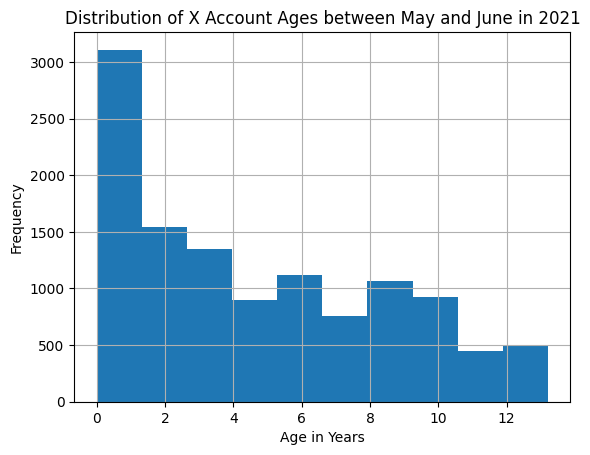

In [67]:
# histogram distribution of account age
df_new['acc_age'].hist()
plt.title('Distribution of X Account Ages between May and June in 2021')
plt.xlabel('Age in Years')
plt.ylabel('Frequency')
plt.show()

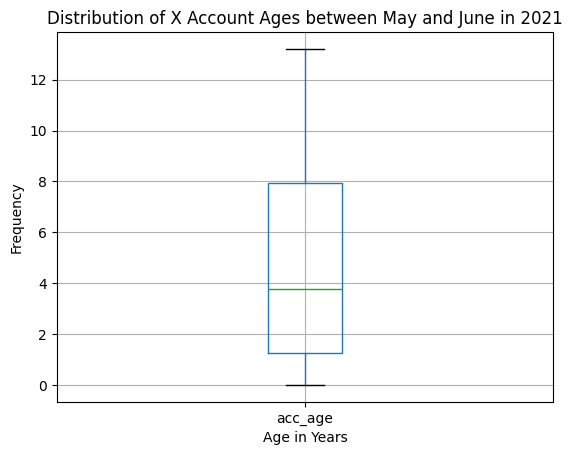

In [68]:
# boxplot distribution of account age
df_new.boxplot(column = 'acc_age')
plt.title('Distribution of X Account Ages between May and June in 2021')
plt.xlabel('Age in Years')
plt.ylabel('Frequency')
plt.show()

<Axes: >

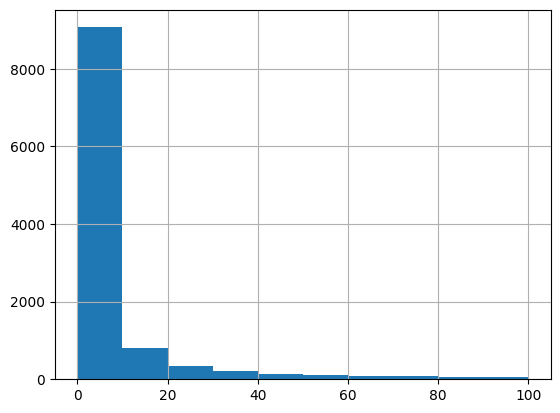

In [69]:
fav_df = df_new[df_new['favorites'] <= 100]
fav_df['favorites'].hist()

<Axes: >

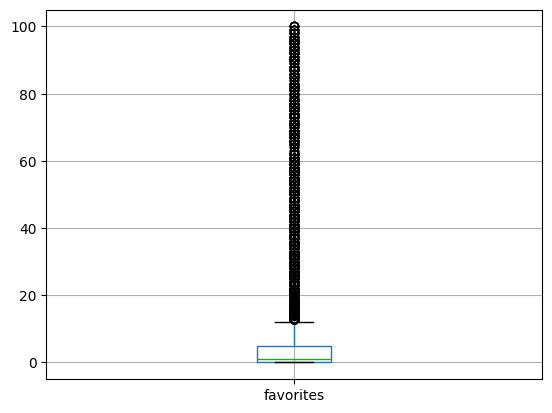

In [70]:
fav_df.boxplot(column = 'favorites')

In [71]:
df_new.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favorites', 'user_verified',
       'date', 'text', 'source', 'retweets', 'favorites', 'day', 'month',
       'year', 'time', 'month_new', 'day_of_week', 'time_of_day', 'twt_length',
       'tweet_count_by_user', 'tweet_engagement', 'acc_age'],
      dtype='object')

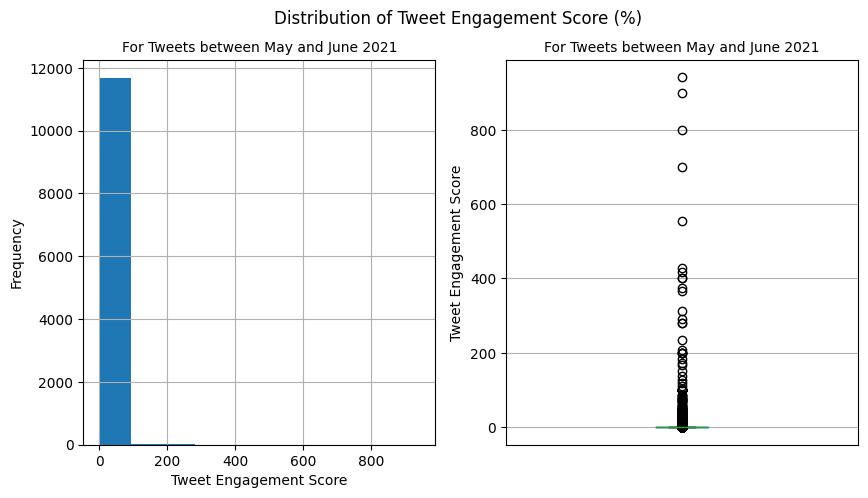

In [72]:
# distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
df_new['tweet_engagement'].hist(ax = ax1)
df_new.boxplot(column = 'tweet_engagement', ax = ax2)

# label
fig.suptitle('Distribution of Tweet Engagement Score (%)')
ax1.set_title('For Tweets between May and June 2021', fontsize = 10)
ax1.set_xlabel('Tweet Engagement Score')
ax1.set_ylabel('Frequency')

ax2.set_title('For Tweets between May and June 2021', fontsize = 10)
ax2.set_xticks([])
ax2.set_ylabel('Tweet Engagement Score')

plt.show()

In [73]:
# summary statistics for tweet_engagement
df_new['tweet_engagement'].describe()

count    11720.000000
mean         1.780293
std         21.084585
min          0.000000
25%          0.000000
50%          0.010000
75%          0.100000
max        941.180000
Name: tweet_engagement, dtype: float64

In [74]:
# 5th and 95th percentile
perc_5 = np.percentile(df_new['tweet_engagement'], 5)
perc_95 = np.percentile(df_new['tweet_engagement'], 95)

print(f'5th percentile: {perc_5}')
print(f'95th percentile: {perc_95}')

5th percentile: 0.0
95th percentile: 3.34


In [75]:
# row where tweet engagement score is 941.18
row_941_18 = df_new[df_new['tweet_engagement'] == 941.18]
with pd.option_context('display.max_columns', None):
    print(row_941_18)
    
# favorites = 151, retweets = 9, tweet_count_by_user = 1, user_followers = 17 
# (((151 + 9)/1)/17)*100 = ((160/1)/17)*100 = (160/17)*100 = 9.41176*100 = 941.18
# if big numerator and small denominator then high tweet engagement score
# it is possible to only have one tweet but have that one tweet receive a lot of engagement

                        id       user_name user_location user_description  \
10583  1404778770360410114  Donner kenneth          <NA>             <NA>   

             user_created  user_followers  user_friends  user_favorites  \
10583 2019-04-20 10:49:33              17            18             244   

       user_verified                date  \
10583          False 2021-06-15 12:32:13   

                                                    text           source  \
10583  @WilliamsRuto I will support William Ruto come...  Twitter Web App   

       retweets  favorites  day  month  year      time month_new day_of_week  \
10583         9        151   15      6  2021  12:32:13       Jun         Tue   

      time_of_day  twt_length  tweet_count_by_user  tweet_engagement  acc_age  
10583   afternoon         140                    1            941.18     2.15  


In [76]:
# tweets that did not receive any engagement
no_eng = df_new[df_new['tweet_engagement'] == 0]
print(f'{no_eng.shape[0]} tweets did not receive any engagement')

# we will filter out tweets that did not receive any engagement. 
# For topic modeling, we are interested in tweets that actually received some form of engagement

5840 tweets did not receive any engagement


## Split the Data


In [78]:
# define label and features
y = df_new['tweet_engagement']
X = df_new.drop(columns = ['id', 'tweet_engagement', 'user_name', 'user_created', 'user_location', 'user_verified',
                           'user_description', 'date', 'source', 'month_new', 'time', 'user_favorites', 'day', 'month', 'year'], 
                    axis = 1)
X.head()

,user_followers,user_friends,text,retweets,favorites,day_of_week,time_of_day,twt_length,tweet_count_by_user,acc_age
0,1053,523,I think it's now safe to say President Uhuru K...,0,0,Sat,early morning,112,1,10.09
1,4202,3735,@_CrazyKenyan President Uhuru Kenyatta bribed ...,0,1,Thu,early evening,138,4,1.27
2,774,1467,"As @HonMoses_Kuria has just been saying,Presid...",0,0,Tue,late evening,140,6,1.32
3,774,1467,David Murathe the KEMSA thief and President Uh...,2,1,Tue,early morning,139,6,1.31
4,774,1467,The Kenyan Senate despite having several elite...,0,0,Mon,early evening,140,6,1.31


In [79]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

In [80]:
X.columns

Index(['user_followers', 'user_friends', 'text', 'retweets', 'favorites',
       'day_of_week', 'time_of_day', 'twt_length', 'tweet_count_by_user',
       'acc_age'],
      dtype='object')

### Winsorization

Applying winsorization on the target value to handle extreme values. In our case, extreme values will be those above the 95th percentile

In [81]:
# filter out tweets with 0 engagement from both the training and test sets of tweet_engagement
y_train = y_train[y_train > 0.00]
y_test = y_test[y_test > 0.00]

y_train.describe()

count    4121.000000
mean        3.538491
std        29.900665
min         0.010000
25%         0.020000
50%         0.100000
75%         0.590000
max       941.180000
Name: tweet_engagement, dtype: float64

In [82]:
y_train.shape

(4121,)

In [83]:
# apply the filtering to the X training and test sets -> ensure that corresponding values have also beein filtered out
X_train = X_train.loc[y_train.index]
X_test = X_test.loc[y_test.index]

In [84]:
X_train.shape

(4121, 10)

In [85]:
y_train_val = y_train.values

# 5th and 95th percentile
perc_5 = np.percentile(y_train_val, 5)
perc_95 = np.percentile(y_train_val, 95)

print(f'5th percentile: {perc_5}')
print(f'95th percentile: {perc_95}')

5th percentile: 0.01
95th percentile: 9.06


In [86]:
# 90% winsorization on tweet_engagement
y_train = mstats.winsorize(y_train, limits = (0.05, 0.05))
y_test = mstats.winsorize(y_test, limits = (0.05, 0.05))

In [87]:
# some summary statistics after winsorization
# convert y_train to a numpy array
y_train_np = y_train.data

y_train_np_df = pd.DataFrame(y_train_np)
y_train_np_df.describe()

,0
count,4121.000000
mean,1.027593
std,2.269165
min,0.010000
25%,0.020000
50%,0.100000
75%,0.590000
max,9.060000


In [88]:
# 5th and 95th percentile
perc_5 = np.percentile(y_train_np, 5)
perc_95 = np.percentile(y_train_np, 95)

print(f'5th percentile: {perc_5}')
print(f'95th percentile: {perc_95}')

5th percentile: 0.01
95th percentile: 9.06


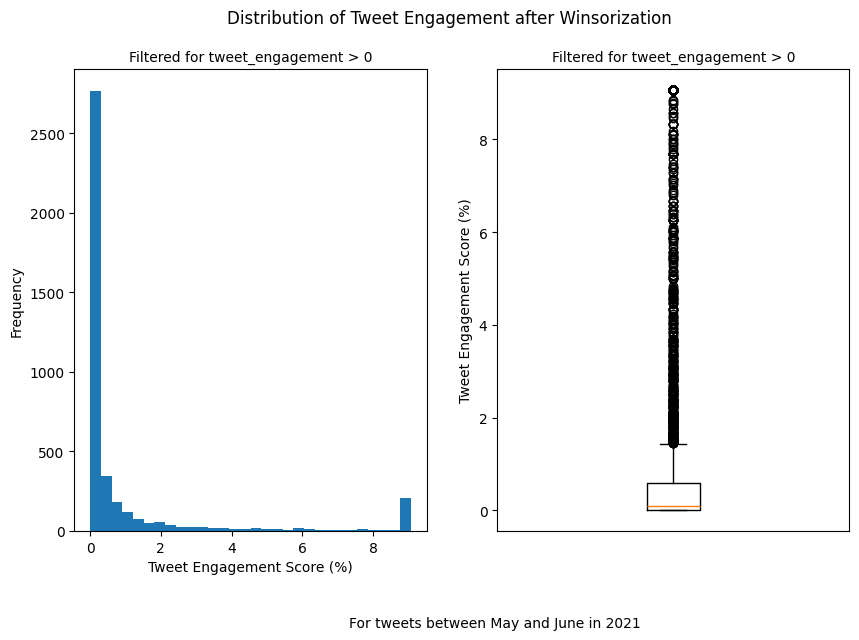

In [89]:
# distribution of tweet_engagement after winsorization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
fig.suptitle('Distribution of Tweet Engagement after Winsorization')
fig.text(0.4, -0.05, 'For tweets between May and June in 2021')

# Extract data from masked array
y_train_data = np.ma.compressed(y_train)

# histogram
ax1.hist(y_train_data, bins = 30)
ax1.set_title('Filtered for tweet_engagement > 0', fontsize = 10) 
ax1.set_xlabel('Tweet Engagement Score (%)')
ax1.set_ylabel('Frequency')

# boxplot
ax2.boxplot(y_train_data, vert = True)
ax2.set_title('Filtered for tweet_engagement > 0', fontsize = 10) 
ax2.set_xticks([])
ax2.set_ylabel('Tweet Engagement Score (%)')

plt.show()

### Text Pre-Processing

One of the goals of in this project is to categorize tweets into major categories to accurately capture the topics that drove most conversation on the plaform in May and June of 2021. This is an unsupervised learning approach. In order to be able to use the text data, we first need to pre-process it to make it usable for this categorization. Some steps we can take are: <br>
<ol>
    <li>Converting all text to lowercase</li>
    <li>Tokenization</li>
    <li>Lemmatization</li>
    <li>Eliminating noise in the text, e.g., removing special characters, punctuation, numbers (optional), HTML tags, URLs, extra whitespace, stopwords</li>
    <li>Word Embeddings</li>

</ol>

In [90]:
# define function -> function will be applied to the features
CLEAN = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def text_preprocessing(text):
    # convert to lower case
    text = text.lower()
    
    # remove html tags
    text = re.sub(CLEAN, '', text)
    
    # remove urls
    text = re.sub(r'http\S+', '', text)
    
    # remove punctuation and special chars
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # tokenize
    tokens = word_tokenize(text)
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]   
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return lemmatized_tokens


In [91]:
# preprocess tweets in the training set and store them in a variable called 'lemma_tok'
start_time = time.time()
X_train['lemma_tok'] = X['text'].apply(text_preprocessing)
X_train.head()
end_time = time.time()
time_taken = (end_time - start_time)
print(f'total execution time: {time_taken} seconds')

total execution time: 3.2004289627075195 seconds


In [92]:
# sample
X_train.sample(n = 1)

,user_followers,user_friends,text,retweets,favorites,day_of_week,time_of_day,twt_length,tweet_count_by_user,acc_age,lemma_tok
8197,1064,978,**FOLLOW or RETWEET I FOLLOW BACK ** Get HTFT ...,2,3,Tue,early morning,140,1,2.61,"[follow, retweet, follow, back, get, htft, mat..."


In [93]:
print(X_train.at[301, 'text'])
print(X_train.at[301, 'lemma_tok'])

@BrianOngere Raila Odinga is tired and punctured. He needs Matiangi more than he needs him. Raila is a limping dog.
['brianongere', 'raila', 'odinga', 'tired', 'punctured', 'need', 'matiangi', 'need', 'raila', 'limping', 'dog']


In [94]:
# preprocess text in the test set and store in a variable called 'lemma_tok'
start_time_text_test = time.time()
X_test['lemma_tok'] = X_test['text'].apply(text_preprocessing)
end_time_text_test = time.time()
time_taken_text_test = end_time_text_test - start_time_text_test
print(f'total execution time: {time_taken_text_test} seconds')

total execution time: 0.38800525665283203 seconds


In [95]:
# drop the text column from both training and test sets
X_train = X_train.drop(columns = 'text')
X_test = X_test.drop(columns = 'text')

X_train.head()

,user_followers,user_friends,retweets,favorites,day_of_week,time_of_day,twt_length,tweet_count_by_user,acc_age,lemma_tok
6848,1357,1639,4,9,Sat,early evening,140,9,6.88,"[history, kenya, writtenone, question, histori..."
4682,745,1303,1,2,Fri,late evening,139,1,1.63,"[williamsruto, together, excellency, hon, will..."
6147,1051,483,1,5,Thu,early morning,140,25,0.88,"[high, court, temporarily, barred, jsc, hearin..."
1924,87641,94,41,139,Fri,afternoon,140,3,6.57,"[justice, martha, koome, take, oath, office, c..."
11041,6448,5891,660,456,Sun,early morning,130,9,6.17,"[who, hand, kenya, safe, president, uhuru, ken..."


## Topic Modeling

In [96]:
# create a dictionary and corpus in the training set
dictionary_train = corpora.Dictionary(X_train['lemma_tok'])
corpus_train = [dictionary_train.doc2bow(text) for text in X_train['lemma_tok']] 

# dictionary is a Corpus dictionary objects that maps each unique word to a unique id
# corpus converts each tweet text into a bag-of-words representation

In [98]:
# apply the LDA model to the training set
num_topics = 4
lda_model_train = LdaModel(corpus_train, num_topics = num_topics, id2word = dictionary_train, passes = 30, random_state = 1234)

# print to see output
print(lda_model_train.print_topics(num_topics = 4, num_words = 3))

[(0, '0.066*"president" + 0.061*"uhuru" + 0.054*"kenyatta"'), (1, '0.016*"ksh" + 0.012*"william" + 0.012*"ruto"'), (2, '0.046*"ruto" + 0.043*"william" + 0.015*"raila"'), (3, '0.026*"ruto" + 0.026*"raila" + 0.023*"william"')]


In [99]:
# above output
# 0: topic number
# linear combo of 3 strings because num_words = 3
# word is 'most meaningful' topic word
# values are relative weights associated with each word

In [100]:
# funciton to assign a topic to a tweet in the training set
def assign_topic_to_tweet(tweet):
    bag_of_words = dictionary_train.doc2bow(tweet)
    twt_topic = lda_model_train.get_document_topics(bag_of_words)
    return max(twt_topic, key = lambda x: x[1])[0] # extract topic label of topic with the highest probability

# apply function to training set
X_train['twt_topic_num'] = X_train['lemma_tok'].apply(assign_topic_to_tweet)
X_train.head()    

,user_followers,user_friends,retweets,favorites,day_of_week,time_of_day,twt_length,tweet_count_by_user,acc_age,lemma_tok,twt_topic_num
6848,1357,1639,4,9,Sat,early evening,140,9,6.88,"[history, kenya, writtenone, question, histori...",1
4682,745,1303,1,2,Fri,late evening,139,1,1.63,"[williamsruto, together, excellency, hon, will...",0
6147,1051,483,1,5,Thu,early morning,140,25,0.88,"[high, court, temporarily, barred, jsc, hearin...",0
1924,87641,94,41,139,Fri,afternoon,140,3,6.57,"[justice, martha, koome, take, oath, office, c...",0
11041,6448,5891,660,456,Sun,early morning,130,9,6.17,"[who, hand, kenya, safe, president, uhuru, ken...",0


In [101]:
# show what topics were generated in the training set
for topic_num in range(num_topics):
    twt_topic = [word for word, prob in lda_model_train.show_topic(topic_num)]
    print(f"topic {topic_num}: {', '.join(twt_topic)}")

topic 0: president, uhuru, kenyatta, kenya, ruto, raila, odinga, william, lamu, port
topic 1: ksh, william, ruto, raila, president, delivery, size, odinga, order, done
topic 2: ruto, william, raila, president, dp, odinga, party, williamsruto, next, jubilee
topic 3: ruto, raila, william, odinga, uhuru, president, kenyatta, kenyan, kenya, like


In [102]:
X_train.sample(n=1)

,user_followers,user_friends,retweets,favorites,day_of_week,time_of_day,twt_length,tweet_count_by_user,acc_age,lemma_tok,twt_topic_num
3606,9356,36,1,7,Wed,mid morning,140,13,0.13,"[president, uhuru, kenyatta, called, increased...",0


In [103]:
print(X_train.at[301, 'lemma_tok'])
print(X_train.at[301, 'twt_topic_num'])

['brianongere', 'raila', 'odinga', 'tired', 'punctured', 'need', 'matiangi', 'need', 'raila', 'limping', 'dog']
3


In [104]:
# assigning general topics
def assign_key_topics(val):
    if val == 0:
        return "Thoughts on Uhuru Kenyatta and His Regime"
    elif val == 1:
        return "Other"
    else:
        return "Thoughts on Presidential Candidates (Raila vs. Ruto)"
    
X_train['twt_topic'] = X_train['twt_topic_num'].apply(assign_key_topics)
X_train.head()

,user_followers,user_friends,retweets,favorites,day_of_week,time_of_day,twt_length,tweet_count_by_user,acc_age,lemma_tok,twt_topic_num,twt_topic
6848,1357,1639,4,9,Sat,early evening,140,9,6.88,"[history, kenya, writtenone, question, histori...",1,Other
4682,745,1303,1,2,Fri,late evening,139,1,1.63,"[williamsruto, together, excellency, hon, will...",0,Thoughts on Uhuru Kenyatta and His Regime
6147,1051,483,1,5,Thu,early morning,140,25,0.88,"[high, court, temporarily, barred, jsc, hearin...",0,Thoughts on Uhuru Kenyatta and His Regime
1924,87641,94,41,139,Fri,afternoon,140,3,6.57,"[justice, martha, koome, take, oath, office, c...",0,Thoughts on Uhuru Kenyatta and His Regime
11041,6448,5891,660,456,Sun,early morning,130,9,6.17,"[who, hand, kenya, safe, president, uhuru, ken...",0,Thoughts on Uhuru Kenyatta and His Regime


In [105]:
# visulalization for the LDA model from the training set
pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim.prepare(lda_model_train, corpus_train, dictionary_train)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.196364  0.086413       1        1  34.932552
2     -0.068196 -0.183968       2        1  26.705742
3      0.049120 -0.053969       3        1  20.858352
1     -0.177288  0.151524       4        1  17.503353, topic_info=           Term         Freq        Total Category  logprob  loglift
9         uhuru  1128.000000  1128.000000  Default  30.0000  30.0000
43     kenyatta   954.000000   954.000000  Default  29.0000  29.0000
6     president  1403.000000  1403.000000  Default  28.0000  28.0000
46         ruto  1055.000000  1055.000000  Default  27.0000  27.0000
21      william   945.000000   945.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1911    odingas    28.187182    55.965308   Topic4  -5.6392   1.0569
93    political    28.313866    81.645076   Topic4  -5.6347   0.6837
163           u    27.708540    90.539667   Topic4  -5.6563   0.5587
405      deputy    28.737086   173.088253   Topic4  -5.6198  -0.0528
948      county    26.089126    52.573879   Topic4  -5.7165   1.0421

[237 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1005      1  0.984245      amnesty
643       1  0.989618       appeal
1425      1  0.960108  appointment
1626      3  0.959727     assembly
377       4  0.993523    available
...     ...       ...          ...
105       3  0.957482          yes
576       2  0.396669    yesterday
576       3  0.020877    yesterday
576       4  0.584565    yesterday
2927      4  0.981387        young

[276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [106]:
# create a dictionary and corpus in the test set
dictionary_test = corpora.Dictionary(X_test['lemma_tok'])
corpus_test = [dictionary_test.doc2bow(text) for text in X_test['lemma_tok']] 

In [107]:
# assign topics to the test set
X_test['twt_topic_num'] = [max(lda_model_train.get_document_topics(bow), key = lambda x: x[1])[0] for bow in corpus_test]
X_test['twt_topic'] = X_test['twt_topic_num'].apply(assign_key_topics)

In [108]:
# drop lemma_tok and twt_topic_num from both training and test sets
X_train = X_train.drop(columns = ['lemma_tok', 'twt_topic_num'])
X_test = X_test.drop(columns = ['lemma_tok', 'twt_topic_num'])

X_train.head()

,user_followers,user_friends,retweets,favorites,day_of_week,time_of_day,twt_length,tweet_count_by_user,acc_age,twt_topic
6848,1357,1639,4,9,Sat,early evening,140,9,6.88,Other
4682,745,1303,1,2,Fri,late evening,139,1,1.63,Thoughts on Uhuru Kenyatta and His Regime
6147,1051,483,1,5,Thu,early morning,140,25,0.88,Thoughts on Uhuru Kenyatta and His Regime
1924,87641,94,41,139,Fri,afternoon,140,3,6.57,Thoughts on Uhuru Kenyatta and His Regime
11041,6448,5891,660,456,Sun,early morning,130,9,6.17,Thoughts on Uhuru Kenyatta and His Regime


## One Hot Encoding

In [109]:
# one hot encoding on the training and test sets
X_train = pd.get_dummies(X_train, columns = ['day_of_week', 'time_of_day', 'twt_topic'])
X_test = pd.get_dummies(X_test, columns = ['day_of_week', 'time_of_day', 'twt_topic'])
X_train.head()

,user_followers,user_friends,retweets,favorites,twt_length,tweet_count_by_user,acc_age,day_of_week_Fri,day_of_week_Mon,day_of_week_Sat,...,day_of_week_Wed,time_of_day_afternoon,time_of_day_early evening,time_of_day_early morning,time_of_day_late evening,time_of_day_mid morning,time_of_day_night,twt_topic_Other,twt_topic_Thoughts on Presidential Candidates (Raila vs. Ruto),twt_topic_Thoughts on Uhuru Kenyatta and His Regime
6848,1357,1639,4,9,140,9,6.88,False,False,True,...,False,False,True,False,False,False,False,True,False,False
4682,745,1303,1,2,139,1,1.63,True,False,False,...,False,False,False,False,True,False,False,False,False,True
6147,1051,483,1,5,140,25,0.88,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1924,87641,94,41,139,140,3,6.57,True,False,False,...,False,True,False,False,False,False,False,False,False,True
11041,6448,5891,660,456,130,9,6.17,False,False,False,...,False,False,False,True,False,False,False,False,False,True


## Modeling - Random Forest Regressor

In [114]:
X_train.columns

Index(['user_followers', 'user_friends', 'retweets', 'favorites', 'twt_length',
       'tweet_count_by_user', 'acc_age', 'day_of_week_Fri', 'day_of_week_Mon',
       'day_of_week_Sat', 'day_of_week_Sun', 'day_of_week_Thu',
       'day_of_week_Tue', 'day_of_week_Wed', 'time_of_day_afternoon',
       'time_of_day_early evening', 'time_of_day_early morning',
       'time_of_day_late evening', 'time_of_day_mid morning',
       'time_of_day_night', 'twt_topic_Other',
       'twt_topic_Thoughts on Presidential Candidates (Raila vs. Ruto)',
       'twt_topic_Thoughts on Uhuru Kenyatta and His Regime'],
      dtype='object')

In [115]:
# determine the number of features that will go into the model
total_features = len(X_train.columns)
print(total_features)

23


In [116]:
# define some variables
num_trees = total_features * 10
num_features = total_features//3

print(f'number of trees: {num_trees}')
print(f'number of features per split: {num_features}')

number of trees: 230
number of features per split: 7


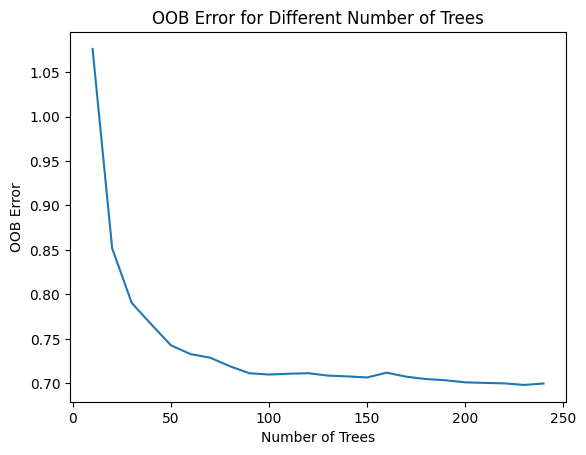

In [123]:
# look at how oob error reduces as number of trees increases

# define a range
start = 10
end = num_trees + 20
step = 10

# create a list for the range of values
num_trees_vals = [i for i in range(start, end, step)]

# initialize lists for the cross-validation, rmse, and r2 scores
oob_errors = []

# iterate
for each_num_trees in num_trees_vals:
    # create model
    rf_model = RandomForestRegressor(n_estimators = each_num_trees, max_features = num_features, oob_score = True, random_state = 1234)
    
    # fit the model
    rf_model.fit(X_train, y_train)
    
    # get the OOB prediction
    oob_pred = rf_model.oob_prediction_
    
    # get the oob error
    oob_error = mean_squared_error(y_train, oob_pred, squared = False)
    
    # append the oob error to the list
    oob_errors.append(oob_error)
    
    
# plot the results
sns.lineplot(x = num_trees_vals, y = oob_errors)
plt.title('OOB Error for Different Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')

plt.show()

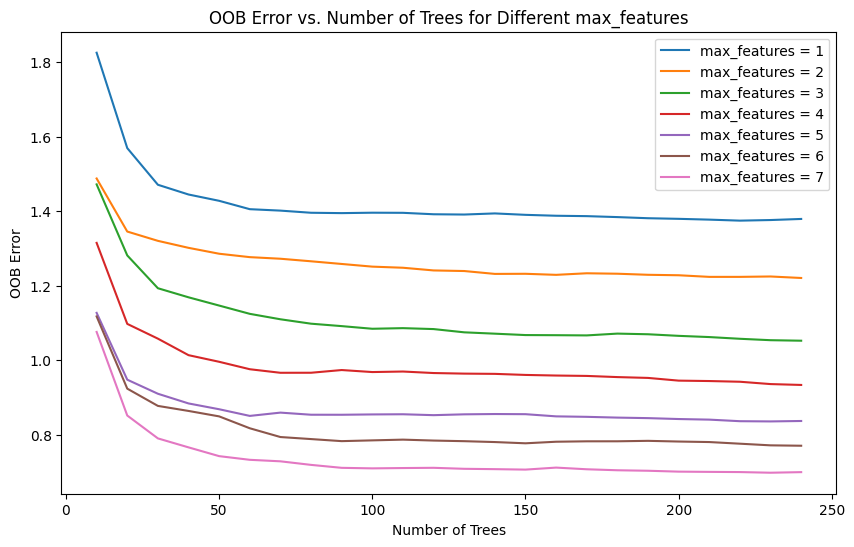

In [124]:
# look at how oob error reduces as number of trees increases

# define a range
start_f = 1
end_f = num_features + 1
step_f = 1

max_features_values = [i for i in range(start_f, end_f, step_f)]

# initialize a list to store OOB errors for each value of max_features
oob_errors_f = []

# iterate over each value of max_features
for max_features in max_features_values:
    # initialize lists to store RMSE scores for each number of trees
    rmse_scores = []
    max_features_oob_errors = []
    
    # iterate over each number of trees
    for each_num_trees in num_trees_vals:
        # Create a random forest model
        rf_model = RandomForestRegressor(n_estimators = each_num_trees, max_features = max_features, oob_score = True, random_state = 1234)
        
        # fit the model to the training data
        rf_model.fit(X_train, y_train)
        
        # get the OOB prediction
        oob_pred = rf_model.oob_prediction_
    
        # get the oob error
        oob_error = mean_squared_error(y_train, oob_pred, squared = False)
        
        # append the OOB error to the list
        max_features_oob_errors.append(oob_error)
        
    # append the list of RMSE scores to the overall list of OOB errors
    oob_errors_f.append(max_features_oob_errors)

# plot the OOB errors for each value of max_features
plt.figure(figsize = (10, 6))

for i, max_features in enumerate(max_features_values):
    plt.plot(num_trees_vals, oob_errors_f[i], label = f"max_features = {max_features}")
    
# sns.lineplot(x = num_trees_vals, y = oob_errors)
    
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("OOB Error vs. Number of Trees for Different max_features")
plt.legend()
plt.show()


In [119]:
# create model
rf_model = RandomForestRegressor(n_estimators = num_trees, max_features = 16)

# # cross-validation score
cv_scores = cross_val_score(rf_model, X_train, y_train, cv = 5)
cv_scores_avg = np.mean(cv_scores)
print(f'Mean CV score: {cv_scores_avg}')

# fit the model
rf_model.fit(X_train, y_train)

# predict
y_rf_predict = rf_model.predict(X_test)

# rmse and r2 score
rf_rmse = mean_squared_error(y_test, y_rf_predict, squared = False)
rf_r2 = r2_score(y_test, y_rf_predict)

# print scores
print(f'root mean squared error: {rf_rmse}')
print(f'r-squared score: {rf_r2}')

Mean CV score: 0.9482081745784787
root mean squared error: 0.5437052532623926
r-squared score: 0.9480436166773666


In [120]:
# feature importance
ftr_imp = rf_model.feature_importances_
ftr_imp_df = pd.DataFrame({'feature': X_train.columns,
                          'importance': np.round(ftr_imp, 5)})
ftr_imp_df = ftr_imp_df.sort_values(by = 'importance', ascending = False)

# display
print(ftr_imp_df.shape)
print('feature importance rank:')
print(ftr_imp_df.head(10))

(23, 2)
feature importance rank:
                      feature  importance
0              user_followers     0.56187
3                   favorites     0.16430
5         tweet_count_by_user     0.13536
1                user_friends     0.05843
2                    retweets     0.03748
6                     acc_age     0.01975
4                  twt_length     0.00545
13            day_of_week_Wed     0.00195
16  time_of_day_early morning     0.00155
12            day_of_week_Tue     0.00141


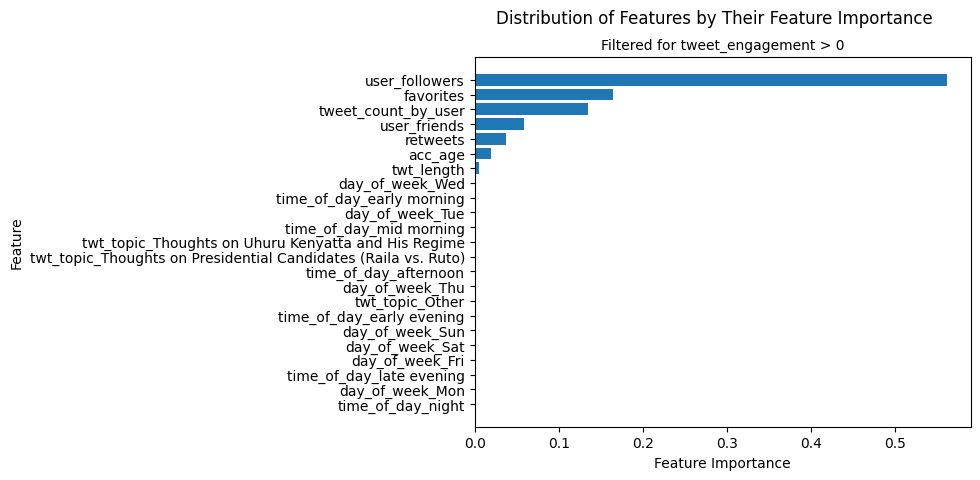

In [121]:
# function to plot all the feature importances
def plot_feature_importances(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.barh(range(len(importances)), importances[indices], align='center')
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.suptitle('Distribution of Features by Their Feature Importance')
    plt.title('Filtered for tweet_engagement > 0', fontsize = 10)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    
# apply function

# define feature_names
feature_names = X_train.columns 

plot_feature_importances(rf_model)

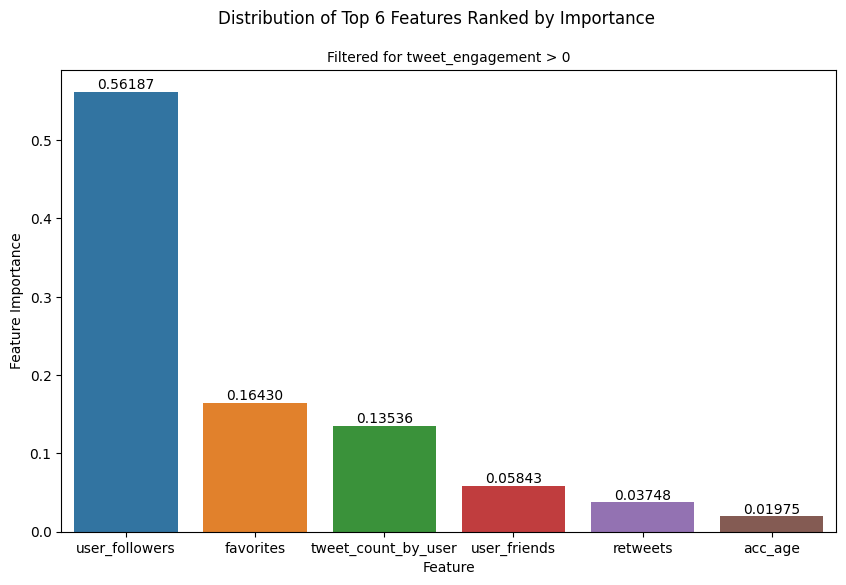

In [122]:
# visualize feature importance
fig, ax = plt.subplots(figsize = (10, 6))
sns.barplot(data = ftr_imp_df, x = ftr_imp_df['feature'][:6],
           y = ftr_imp_df['importance'][:6], hue = ftr_imp_df['feature'][:6], ax = ax)

# function to wrap the labes on the x-axis
def wrap_text(ax, width, break_long_words = False):
  labels = []
  for label in ax.get_xticklabels():
    text = label.get_text()
    labels.append(textwrap.fill(text, width = width, break_long_words = break_long_words))
  ax.set_xticklabels(labels, rotation = 0)

for i, (index, row) in enumerate(ftr_imp_df[:6].iterrows()):
    plt.text(i, row['importance'], f'{row["importance"]:.5f}', ha='center', va='bottom')
    
fig.suptitle('Distribution of Top 6 Features Ranked by Importance')
ax.set_title('Filtered for tweet_engagement > 0', fontsize = 10)
ax.set_xlabel('Feature')
ax.set_ylabel('Feature Importance')

wrap_text(ax, 2)
plt.show()